In [1]:
! git clone https://github.com/jhonatansossa/deep-learning-project-JS.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Dependencias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import plotly.graph_objs as go
import plotly.offline as pyoff
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#### Importar maestro con dummies

In [3]:
df_maestro_dummies = pd.read_parquet(r'/content/deep-learning-project-JS/data/04_model_input/dummies_master.parquet.snappy', engine='pyarrow')  
df_maestro_agregado = pd.read_parquet(r'/content/deep-learning-project-JS/data/03_primary/aggregated_master.parquet.snappy', engine='pyarrow')  
#df_maestro_dummies = df_maestro_dummies.set_index('date')
df_maestro_dummies

,date,store_nbr,sales,onpromotion,rezago_onpromotion_1,rezago_onpromotion_2,rezago_onpromotion_3,rezago_onpromotion_4,cluster,dcoilwtico,...,state_manabi,state_pastaza,state_pichincha,state_santa_elena,state_santo_domingo_de_los_tsachilas,state_tungurahua,type_b,type_c,type_d,type_e
8910,2013-03-10,1,7.000000,0,0.0,0.0,0.0,0.0,13,91.004,...,0,0,1,0,0,0,0,0,1,0
8911,2013-03-10,1,0.000000,0,0.0,0.0,0.0,0.0,13,91.004,...,0,0,1,0,0,0,0,0,1,0
8912,2013-03-10,1,12.000000,0,0.0,0.0,0.0,0.0,13,91.004,...,0,0,1,0,0,0,0,0,1,0
8913,2013-03-10,1,6803.000000,0,0.0,0.0,0.0,0.0,13,91.004,...,0,0,1,0,0,0,0,0,1,0
8914,2013-03-10,1,0.000000,0,0.0,0.0,0.0,0.0,13,91.004,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422329,2017-08-13,54,486.995996,10,8.0,9.0,9.0,11.0,3,49.076,...,1,0,0,0,0,0,0,1,0,0
422330,2017-08-13,54,543.000000,0,0.0,1.0,0.0,0.0,3,49.076,...,1,0,0,0,0,0,0,1,0,0
422331,2017-08-13,54,4620.846000,91,97.0,118.0,163.0,175.0,3,49.076,...,1,0,0,0,0,0,0,1,0,0
422332,2017-08-13,54,0.000000,0,0.0,0.0,0.0,0.0,3,49.076,...,1,0,0,0,0,0,0,1,0,0


#### Separando los conjuntos de entramiento y test

In [6]:
df_model = df_maestro_dummies.set_index('date')
df_model = df_model.loc[:, ['diff_sales'] + list(df_model.columns.drop('diff_sales'))]
#split train and test set
train_set, test_set = df_model[:'2016'].reset_index().drop(['sales', 'date'],axis=1).values, df_model['2017':].reset_index().drop(['sales', 'date'],axis=1).values

#### Escalando las características entre 0 y 1

In [7]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)
# reshape validation set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

#### Construyendo el modelo LSTM

In [8]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [9]:
#No se requiere entrenar ya que el modelo está guardado en el datalake
"""model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1, shuffle=False)"""

Epoch 1/5
354618/354618 [==============================] - 866s 2ms/step - loss: 5.5166e-05
Epoch 2/5
354618/354618 [==============================] - 840s 2ms/step - loss: 5.3652e-05
Epoch 3/5
354618/354618 [==============================] - 833s 2ms/step - loss: 5.1141e-05
Epoch 4/5
354618/354618 [==============================] - 840s 2ms/step - loss: 3.1907e-05
Epoch 5/5
354618/354618 [==============================] - 835s 2ms/step - loss: 2.3874e-05


Guardar LSTM model

In [10]:
#model.save(r'/content/deep-learning-project-JS/data/05_model/lstm_model.h5')

Cargar LSTM model

In [11]:
model = keras.models.load_model(r'/content/deep-learning-project-JS/data/05_model/lstm_model.h5')

Predicción

In [12]:
y_pred_lstm = model.predict(X_test,batch_size=1)

58806/58806 [==============================] - 98s 2ms/step


Devolviendo la predicción a la escala original

In [14]:
#rebuild test set for inverse transform
pred_lstm_test_set = np.hstack([y_pred_lstm, X_test.reshape(X_test.shape[0], X_test.shape[2])])
#inverse transform
pred_lstm_test_set_inverted = scaler.inverse_transform(pred_lstm_test_set)

#### XGBoost Model

In [15]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]

In [16]:
#No se requiere entrenar ya que el modelo está guardado en el datalake
"""reg = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train"""

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

Guardar XGBoost model

In [18]:
#reg.save_model("/content/deep-learning-project-JS/data/05_model/xgboost_model.json")

Cargar XGBoost Model

In [19]:
reg = xgb.XGBRegressor()
reg.load_model("/content/deep-learning-project-JS/data/05_model/xgboost_model.json")

Predicción

In [20]:
y_pred_xgboost = reg.predict(X_test)

Devolviendo la predicción a la escala original

In [24]:
#rebuild test set for inverse transform
pred_xgboost_test_set = np.hstack([y_pred_xgboost.reshape(y_pred_xgboost.shape[0], 1), X_test.reshape(X_test.shape[0], X_test.shape[1])])
#inverse transform
pred_xgboost_test_set_inverted = scaler.inverse_transform(pred_xgboost_test_set)

Agregando la predicción a la maestra

In [25]:
df_master_pred = df_maestro_agregado[['date', 'store_nbr', 'family', 'sales', 'diff_sales']].set_index('date')['2017':].reset_index()
df_master_pred['diff_sales_pred_lstm'] = pred_lstm_test_set_inverted[:,0:1]
df_master_pred['diff_sales_pred_xgboost'] = pred_xgboost_test_set_inverted[:,0:1]
df_master_pred = df_master_pred.sort_values(by=['family', 'store_nbr', 'date'])

df_master_pred

,date,store_nbr,family,sales,diff_sales,diff_sales_pred_lstm,diff_sales_pred_xgboost
0,2017-01-01,1,automotive,26.0,-2.0,2.715498,7.731067
1782,2017-01-08,1,automotive,19.0,-7.0,-157.866173,7.731067
3564,2017-01-15,1,automotive,23.0,4.0,15.796952,7.731067
5346,2017-01-22,1,automotive,20.0,-3.0,15.394796,7.731067
7128,2017-01-29,1,automotive,37.0,17.0,20.789757,7.731067
...,...,...,...,...,...,...,...
51677,2017-07-16,54,seafood,21.0,-1.0,3.679155,7.731067
53459,2017-07-23,54,seafood,20.0,-1.0,20.243432,7.731067
55241,2017-07-30,54,seafood,25.0,5.0,34.614820,7.731067
57023,2017-08-06,54,seafood,18.0,-7.0,12.412771,7.731067


#### Deshaciendo la diferenciación

In [26]:
df_master_pred['sales_pred_lstm'] = df_master_pred.groupby(['family', 'store_nbr'])['sales'].shift(1) + df_master_pred['diff_sales_pred_lstm']
df_master_pred['sales_pred_xgboost'] = df_master_pred.groupby(['family', 'store_nbr'])['sales'].shift(1) + df_master_pred['diff_sales_pred_xgboost']
df_master_pred = df_master_pred.dropna()

df_master_pred

,date,store_nbr,family,sales,diff_sales,diff_sales_pred_lstm,diff_sales_pred_xgboost,sales_pred_lstm,sales_pred_xgboost
1782,2017-01-08,1,automotive,19.0,-7.0,-157.866173,7.731067,-131.866173,33.731067
3564,2017-01-15,1,automotive,23.0,4.0,15.796952,7.731067,34.796952,26.731067
5346,2017-01-22,1,automotive,20.0,-3.0,15.394796,7.731067,38.394796,30.731067
7128,2017-01-29,1,automotive,37.0,17.0,20.789757,7.731067,40.789757,27.731067
8910,2017-02-05,1,automotive,26.0,-11.0,18.907970,7.731067,55.907970,44.731067
...,...,...,...,...,...,...,...,...,...
51677,2017-07-16,54,seafood,21.0,-1.0,3.679155,7.731067,25.679155,29.731067
53459,2017-07-23,54,seafood,20.0,-1.0,20.243432,7.731067,41.243432,28.731067
55241,2017-07-30,54,seafood,25.0,5.0,34.614820,7.731067,54.614820,27.731067
57023,2017-08-06,54,seafood,18.0,-7.0,12.412771,7.731067,37.412771,32.731067


Evaluando las predicciones

In [ ]:
#LSTM error
np.sqrt(mean_squared_error(df_master_pred.sales,df_master_pred.sales_pred_lstm))

In [ ]:
#XGBoost error
np.sqrt(mean_squared_error(df_master_pred.sales,df_master_pred.sales_pred_xgboost))

Guardar maestra de predicciones

In [35]:
df_master_pred.to_parquet(r'/content/deep-learning-project-JS/data/06_model_output/forecast_master.parquet.snappy', compression='snappy') 

#### Revisando el resultado para las familias y los puntos de venta desagregados

In [45]:
df_master_pred.family.unique()

array(['automotive', 'baby care', 'beauty', 'beverages', 'books',
       'bread/bakery', 'celebration', 'cleaning', 'dairy', 'deli', 'eggs',
       'frozen foods', 'grocery i', 'grocery ii', 'hardware',
       'home and kitchen i', 'home and kitchen ii', 'home appliances',
       'home care', 'ladieswear', 'lawn and garden', 'lingerie',
       'liquor,wine,beer', 'magazines', 'meats', 'personal care',
       'pet supplies', 'players and electronics', 'poultry',
       'prepared foods', 'produce', 'school and office supplies',
       'seafood'], dtype=object)

In [46]:
family = 'beverages'
store_nbr = 40
copiar = df_master_pred.loc[(df_master_pred['family'] == family) & (df_master_pred['store_nbr'] == store_nbr)]

In [47]:
df1 = copiar.copy(deep = True)
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date',inplace = True)
df1 = df1.resample('W').sum()

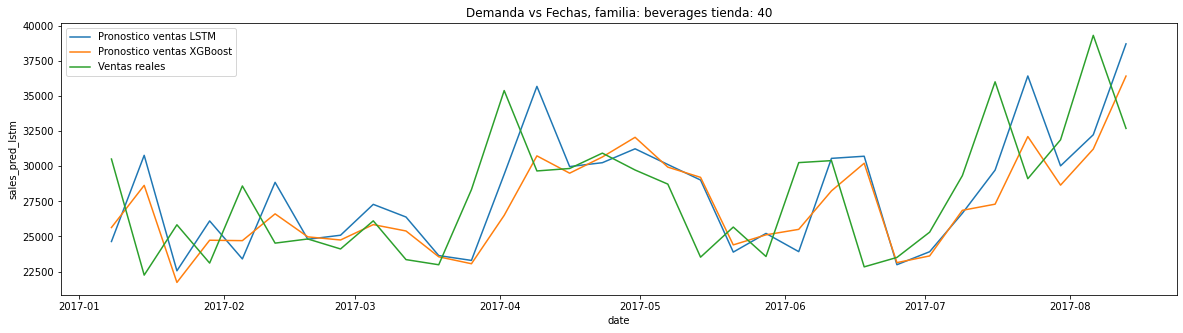

In [48]:
color1 = ['#296C92','#3EB489']
plt.figure(figsize = (20,5))
sns.lineplot(x = df1.index ,y = df1["sales_pred_lstm"],data = df1,palette = color1);
sns.lineplot(x = df1.index ,y = df1["sales_pred_xgboost"],data = df1,palette = color1);
sns.lineplot(x = df1.index ,y = df1["sales"],data = df1,palette = color1);
plt.legend(labels=["Pronostico ventas LSTM", "Pronostico ventas XGBoost", "Ventas reales"])
plt.title('Demanda vs Fechas, familia: ' + family + ' tienda: ' + str(store_nbr))

plt.show()

#### Revisando el resultado agregado

In [51]:
df1 = df_master_pred.copy(deep = True)
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date',inplace = True)
df1 = df1.resample('W').sum()

In [52]:
df2 = df_model.reset_index()[['date', 'sales']].copy(deep = True)
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date',inplace = True)
df2 = df2.resample('W').sum()

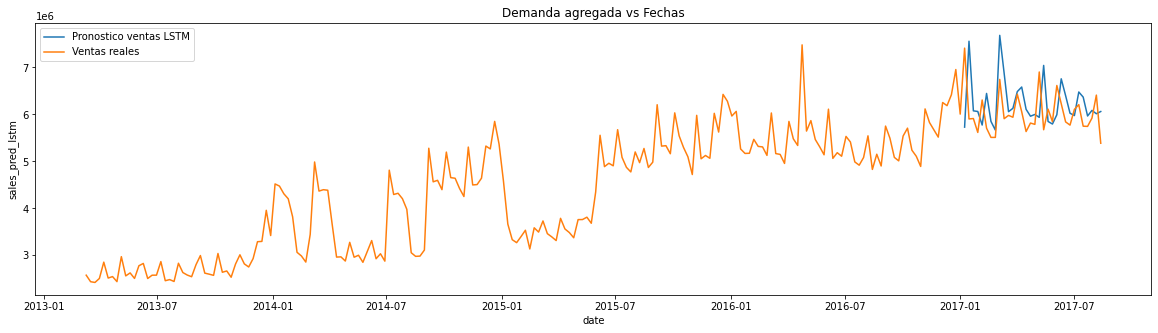

In [54]:
color1 = ['#296C92','#3EB489']
plt.figure(figsize = (20,5))
sns.lineplot(x = df1.index ,y = df1["sales_pred_lstm"],data = df1,palette = color1);
sns.lineplot(x = df2.index ,y = df2["sales"],data = df2,palette = color1);
plt.title('Demanda agregada vs Fechas')
plt.legend(labels=["Pronostico ventas LSTM", "Ventas reales"])

plt.show()

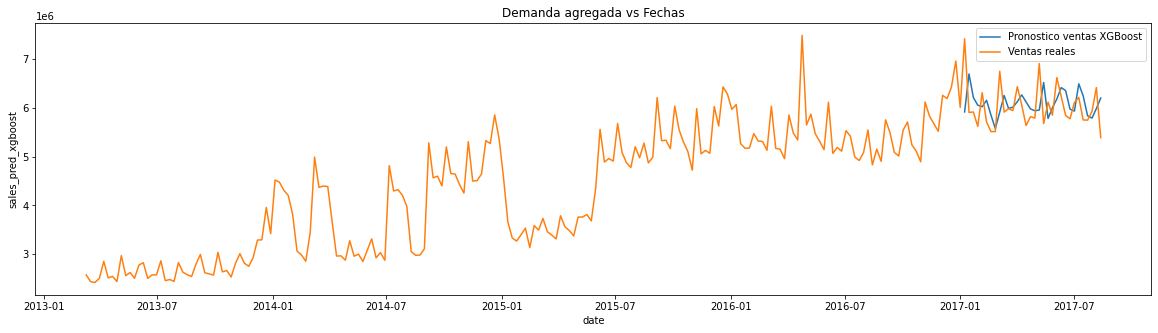

In [55]:
color1 = ['#296C92','#3EB489']
plt.figure(figsize = (20,5))
sns.lineplot(x = df1.index ,y = df1["sales_pred_xgboost"],data = df1,palette = color1);
sns.lineplot(x = df2.index ,y = df2["sales"],data = df2,palette = color1);
plt.title('Demanda agregada vs Fechas')
plt.legend(labels=["Pronostico ventas XGBoost", "Ventas reales"])

plt.show()